# Mouse snRNA Integrative Analysis
## Cortex
### Data
- [Cortex data table](https://github.com/erebboah/enc4_mouse/blob/master/snrna/ref/cortex_minimal_metadata.tsv)

### Aims
[integrate_parse_10x.R](https://github.com/erebboah/enc4_mouse/blob/master/snrna/scripts/integrate_parse_10x.R):
1. Read in pre-processed Parse and 10x data and merge counts matrices across experiments (within the same technology) for each tissue.
2. Filter nuclei by # genes, # UMIs, percent mitochondrial gene expression, and doublet score. See [detailed metadata](https://github.com/erebboah/enc4_mouse/blob/master/snrna/ref/enc4_mouse_snrna_metadata.tsv) for filter cutoffs.
3. Run SCT on the 3 objects to regress `percent.mt` and `nFeature_RNA`. Use  `method = "glmGamPoi"` to speed up this step, and save pre-integrated data in `seurat` folder. **Also filter 10x nuclei for those passing snATAC filters.**
4. Combine Parse standard, Parse deep, and 10x data by CCA integration. Use Parse standard as reference dataset because it contains all timepoints, while 10x data only contains 2 timepoints. 
5. Score nuclei by cell cycle using these [mouse cell cycle genes](https://github.com/erebboah/enc4_mouse/blob/master/snrna/ref/mouse_cellcycle_genes.rda) to aid in manual celltype annotation.

[predict_cortex_celltypes.R](https://github.com/erebboah/enc4_mouse/blob/master/snrna/scripts/predict_cortex_celltypes.R): Use an [external 10x brain atlas](https://portal.brain-map.org/atlases-and-data/rnaseq/mouse-whole-cortex-and-hippocampus-10x) to predict celltype labels. The 1.1M cell dataset was subset for 1,000 cells in each celltype for a ~250,000 cell dataset (code coming soon).

**In this notebook**:
Manual celltype annotation by assigning each cluster to the celltype predicted for the majority of cells in the cluster, then adjusting the labels as we see fit. Find marker genes for `gen_celltype`, `celltypes`, and `subtypes` and save in `seurat/markers`.

### Results
- We decided on 3 levels of annotation: `gen_celltype` or general celltype (e.g. "Neuron"), `celltypes` for higher resolution (e.g. "Inhibitory"), and finally `subtypes` for the highest resolution of celltype annotations (e.g. "Pvalb"). 
- The external atlas did not separate their oligodendrocytes into OPCs, MFOLs, and MOLs, but we use marker genes reported in literature and on [mousebrain.org](http://www.mousebrain.org/adolescent/celltypes.html) to check marker genes and assign cell type labels.


In [1]:
library(Matrix)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(viridis))
library(glmGamPoi)
library(RColorBrewer)
options(future.globals.maxSize = 10000 * 1024^2)
future.seed=TRUE


Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"


In [ ]:
setwd("../../enc4_mouse/snrna/")

In [2]:
setwd("/share/crsp/lab/seyedam/share/enc4_mouse/snrna/")

In [3]:
system("mkdir plots/cortex")
system("mkdir plots/cortex/qc")
system("mkdir plots/cortex/clustering")
system("mkdir plots/cortex/annotation")
system("mkdir seurat/markers")
system("mkdir ref/cortex")

# Functions

In [4]:
get_orig_counts = function(file){
    metadata = metadata[metadata$file_accession == file,]
    counts = readMM(paste0("counts_10x/",file,"/matrix.mtx"))
    
    barcodes = read.delim(paste0("counts_10x/",file,"/barcodes.tsv"),header = F, col.names="barcode")
    features = read.delim(paste0("counts_10x/",file,"/genes.tsv"),header = F, col.names="gene_name") 
    colnames(counts) = barcodes$barcode
    rownames(counts) = features$gene_name
    out = counts

}

In [5]:
knee_df = function(mtx,expt_name){
    df = as.data.frame(rowSums(mtx))
    colnames(df) = c("nUMI")
    df <- tibble(total = df$nUMI,
               rank = row_number(dplyr::desc(total))) %>%
    distinct() %>%
    arrange(rank)
    df$experiment = expt_name
    out = df
}

# QC plots

## Knee plot

In [6]:
combined.sct = readRDS("seurat/cortex_Parse_10x_integrated.rds")
cellbend_10x = subset(combined.sct,subset=technology =="10x")
orig_parse = subset(combined.sct,subset=technology =="Parse")
parse_standard = subset(orig_parse,subset=depth1 =="shallow")
parse_deep = subset(orig_parse,subset=depth1 =="deep")

In [7]:
metadata = read.delim("ref/enc4_mouse_snrna_metadata.tsv")
metadata = metadata[metadata$technology == "10x",]
metadata = metadata[metadata$tissue == "Cortex",]

files = metadata$file_accession

orig_10x = get_orig_counts(files[1])

for (j in 2:length(files)){
    counts_adding = get_orig_counts(files[j])
    orig_10x = cbind(orig_10x, counts_adding)
}


In [8]:
cellbend_knee_plot = knee_df(cellbend_10x@assays$RNA@counts, "10x + Cellbender")
orig_knee_plot = knee_df(orig_10x, "10x")

parse_standard_knee_plot = knee_df(parse_standard@assays$RNA@counts, "Parse standard")
parse_deep_knee_plot = knee_df(parse_deep@assays$RNA@counts, "Parse deep")

pdf(file="plots/cortex/qc/experiment_kneeplots.pdf",
    width = 10, height = 8)
ggplot(rbind(cellbend_knee_plot,orig_knee_plot,parse_standard_knee_plot,parse_deep_knee_plot), 
       aes(rank, total, group = experiment, color = experiment)) +
geom_path() + 
scale_y_log10() + scale_x_log10() + annotation_logticks() +
labs(y = "Total UMI count", x = "Barcode rank", title = "Mouse cortex knee plot") + 
geom_hline(yintercept=500, linetype="dashed", color = "red", size=1)
dev.off()


Warning message:
"Transformation introduced infinite values in continuous y-axis"


png 
  2

In [9]:
pdf(file="plots/cortex/qc/experiment_violinplots.pdf",
    width = 20, height = 5)
VlnPlot(combined.sct, features = c("nFeature_RNA"), ncol = 1, split.by = "depth2",
        pt.size = 0, group.by = "sample", cols = c("#811b74","#C08DBA","#00a1e0"))+ ggtitle("# genes per nucleus") +
stat_summary(fun.y = median, geom='point', size = 15, colour = "black", shape = 95) & theme(text = element_text(size = 20), 
                                                                              axis.text.x = element_text(size = 20), 
                                                                              axis.text.y = element_text(size = 20))
VlnPlot(combined.sct, features = c("nCount_RNA"), ncol = 1, split.by = "depth2",
        pt.size = 0, group.by = "sample", cols = c("#811b74","#C08DBA","#00a1e0")) + ggtitle("# UMIs per nucleus") +
stat_summary(fun.y = median, geom='point', size = 15, colour = "black", shape = 95)& theme(text = element_text(size = 20), 
                                                  axis.text.x = element_text(size = 20), 
                                                  axis.text.y = element_text(size = 20))
VlnPlot(combined.sct, features = c("percent.mt"), ncol = 1, split.by = "depth2",
        pt.size = 0, group.by = "sample", cols = c("#811b74","#C08DBA","#00a1e0")) & theme(text = element_text(size = 20), 
                                                  axis.text.x = element_text(size = 20), 
                                                  axis.text.y = element_text(size = 20)) 
dev.off()

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.

Warning message:
"`fun.y` is deprecated. Use `fun` instead."
Warning message:
"`fun.y` is deprecated. Use `fun` instead."


png 
  2

## UMAP "Feature Plots" of QC metadata

In [10]:
png(file="plots/cortex/qc/qc_featureplot.png",
    width = 1200, height = 500)

FeaturePlot(combined.sct, pt.size = 0.1,
            features =c("nFeature_RNA",
                        "nCount_RNA",
                        "percent.mt",
                        "percent.ribo",
                        "doublet_scores",
                        "G2M.Score"), ncol =3,order=T)  & scale_colour_gradientn(colours = viridis(11)) & 
                        NoAxes()& 
                        theme(text = element_text(size = 18))

dev.off()


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



png 
  2

# Check integration and clustering

In [4]:
combined.sct = readRDS("seurat/cortex_Parse_10x_integrated.rds")


In [109]:
nclusters = length(unique(combined.sct$seurat_clusters))
cluster_cols = colorRampPalette(brewer.pal(9,"Set1"))(nclusters)

In [110]:
pdf(file="plots/cortex/clustering/UMAP_Parse_10x.pdf",
    width = 20, height = 8)
p1 <- DimPlot(combined.sct, reduction = "umap", group.by = "technology")
p2 <- DimPlot(combined.sct, reduction = "umap", label = TRUE, repel = TRUE, cols = cluster_cols)
p1 + p2

dev.off()

png 
  2

In [111]:
pdf(file="plots/cortex/clustering/Parse_10x_experiment_distribution.pdf",
    width = 20, height = 6)
DimPlot(combined.sct, reduction = "umap", group.by = "seurat_clusters",split.by = "depth2", label = TRUE, label.size = 6, repel = TRUE, shuffle = T,cols = cluster_cols)

ggplot(combined.sct@meta.data, aes(x=seurat_clusters, fill=depth2)) + geom_bar(position = "fill") & 
theme(text = element_text(size = 20), axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20))

dev.off()


png 
  2

In [112]:
combined.sct$sample = factor(combined.sct$sample, levels=paste0("C_",rep(c("4","10","14","25","36","2m","18m"),each=4),rep(c("_M","_F"),each=2),c("_1","_2")))

pdf(file="plots/cortex/clustering/UMAP_cluster_sample_barplot.pdf",
    width = 20, height = 10)
p1=DimPlot(combined.sct, reduction = "umap", group.by = "seurat_clusters", label = TRUE, label.size = 8, repel = TRUE, 
          cols = cluster_cols)
p2=ggplot(combined.sct@meta.data, aes(x=seurat_clusters, fill=sample)) + geom_bar(position = "fill") +
theme(text = element_text(size = 20), axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20)) & coord_flip()
gridExtra::grid.arrange(
  p1, p2,
  widths = c(2,1.6),
  layout_matrix = rbind(c(1, 2)))

dev.off()

png 
  2

In [113]:
pdf(file="plots/cortex/clustering/age_sex_barplot.pdf",
    width = 18, height = 19)
p1=DimPlot(combined.sct, reduction = "umap", group.by = "timepoint", label = TRUE, label.size = 5, repel = TRUE)
p2 = ggplot(combined.sct@meta.data, aes(x=seurat_clusters, fill=timepoint)) + geom_bar(position = "fill") & 
theme(text = element_text(size = 20), axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20)) & coord_flip()

p3=DimPlot(combined.sct, reduction = "umap", group.by = "sex", label = TRUE, label.size = 5, repel = TRUE, shuffle = T)
p4 = ggplot(combined.sct@meta.data, aes(x=seurat_clusters, fill=sex)) + geom_bar(position = "fill") & 
theme(text = element_text(size = 20), axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20)) & coord_flip()
gridExtra::grid.arrange(
  p1, p2, p3, p4,
  widths = c(2,1),
  layout_matrix = rbind(c(1, 2),
                        c(3, 4)))

dev.off()

png 
  2

# Plotting: check predicted celltypes

In [114]:
pdf(file="plots/cortex/annotation/UMAP_predictions.pdf",
    width = 15, height = 12)
nclusters = length(unique(combined.sct$atlas_predictions))
DimPlot(combined.sct, reduction = "umap", group.by = "atlas_predictions",
        label = TRUE, label.size = 6, repel = TRUE,cols = colorRampPalette(brewer.pal(9,"Set1"))(nclusters)) + NoLegend()
dev.off()

png 
  2

# Rename clusters based on maximum predicted celltype

In [148]:
Idents(combined.sct) = "seurat_clusters"
mat = as.matrix(table(Idents(combined.sct), combined.sct$atlas_predictions))
ct = data.frame(atlas_celltypes = colnames(mat)[max.col(mat)])
ct$seurat_clusters = 0:(nrow(ct)-1)
ct$seurat_clusters = factor(ct$seurat_clusters, levels = 0:(nrow(ct)-1))
ct$atlas_celltypes = paste0(ct$atlas_celltypes, ".", ct$seurat_clusters)

metadata = as.data.frame(combined.sct@meta.data)
metadata = left_join(metadata, ct)

combined.sct$atlas_celltypes = metadata$atlas_celltypes

Joining, by = "seurat_clusters"


In [149]:
pdf(file="plots/cortex/annotation/UMAP_maximum_predictions.pdf",
    width = 15, height = 12)

#options(repr.plot.width=20,repr.plot.height=20)

nclusters = length(unique(combined.sct$atlas_celltypes))
DimPlot(combined.sct, reduction = "umap", group.by = "atlas_celltypes",
        label = TRUE, label.size = 4, repel = TRUE,cols = colorRampPalette(brewer.pal(9,"Set1"))(nclusters))  & NoLegend()
dev.off()


png 
  2

# Manual celltype annotation
L2/3 IT RHP and CA3 don't seem neuronal???

L6 IT CT doesn't have nice Foxp2 marker...interneuron markers?

Sncg NOT accurate

## Fix oligodendrocyte clusters

In [153]:
combined.sct$subtypes = combined.sct$atlas_celltypes

combined.sct$subtypes = gsub("\\<Oligo.6\\>","OPC.6",combined.sct$subtypes) 
combined.sct$subtypes = gsub("\\<Oligo.44\\>","OPC.44",combined.sct$subtypes) 
combined.sct$subtypes = gsub("\\<Oligo.59\\>","OPC.59",combined.sct$subtypes) 
combined.sct$subtypes = gsub("\\<Oligo.30\\>","MFOL.30",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<Oligo.20\\>","MOL.20",combined.sct$subtypes) 


## Fix clusters

In [154]:
combined.sct$subtypes = gsub("\\<CA3.31\\>","Astro.31",combined.sct$subtypes) 
combined.sct$subtypes = gsub("\\<Lamp5.36\\>","Meis2.36",combined.sct$subtypes) 


In [156]:
# get rid of cluster #
combined.sct$subtypes = do.call("rbind", strsplit(as.character(combined.sct$subtypes), "[.]"))[,1]


## Change some names and check UMAP

In [157]:
combined.sct$subtypes = gsub("\\<Astro\\>","Astrocyte",combined.sct$subtypes) 
combined.sct$subtypes = gsub("\\<Endo\\>","Endothelial",combined.sct$subtypes) 


In [22]:
genes = c( "Gfap","Slc1a2","Slc1a3","Gja1", # astro
          "Mki67","Top2a", # astrocyte/neural progenitors
                                   "Pde1a","Galntl6","Cpne4","Hs3st4",# TEGLUs
                                   "Ndnf","Reln","Trp73", # cajal-retzius
                                    "Car3",
                                    "Bhlhe22","Igfbpl1", # early DG
          "Flt1","Myl9","Xdh", # endothelial 
                                   "Dnah6","Dnah12", "Ccdc153",# ependymal
                                   "Nr4a2","Hs3st2","Tshz2",
                                    "Vwc2l", # near-projecting
                                   "Lamp5","Lhx6",
                                   "Pdgfra","Sox6","C1ql1",# OPC
                                   "Csf1r","Cx3cr1","P2ry12",# microglia
                                   "Plp1","Mbp","Ccp110",# MFOL
                                   "Mog","Opalin","Ninj2","Hapln2","Dock5", # MOL
                                   "Sncg","Sst",
                                   "Dcn","Slc6a13","Ptgds",  # VLMC
                                   "Vip","Meis2","Cobll1","Syt6",
                                    "Foxp2","Rasgrf2","Gad1","Gad2", "Slc17a7","Rorb","Snap25"
          )
        


# Gad1, Gad2, Slc31a2, Gat inhibitory
# Slc17a6

In [23]:
# dot plot of some marker genes
# http://www.mousebrain.org/adolescent/celltypes.html
# https://www.nature.com/articles/s41586-018-0642-9
pdf(file="plots/cortex/annotation/subtypes_marker_dotplot.pdf",
   width = 20, height = 15)

options(repr.plot.width=20,repr.plot.height=10)

DefaultAssay(combined.sct) = "SCT" # do NOT use integrated assay to visualize gene expression
Idents(combined.sct) = "subtypes"
Idents(combined.sct) = factor(Idents(combined.sct), levels = sort(as.character(unique(Idents(combined.sct)))))
DotPlot(combined.sct, features = genes)+ 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
dev.off()

png 
  2

In [37]:
table(combined.sct$subtypes)


   Astrocyte          CA3           CR         Car3  Endothelial   L2 IT ENTl 
        8243          242          259          884         2215          860 
  L2 IT ENTm  L2/3 IT CTX L2/3 IT ENTl  L2/3 IT PPP  L2/3 IT RHP    L3 IT ENT 
         271        17433         3969         2863         1563          912 
 L4/5 IT CTX    L5 IT CTX    L5 PT CTX  L5/6 NP CTX    L6 CT CTX    L6 IT CTX 
       14111         3489         2885         1353         6605         4029 
  L6b/CT ENT        Lamp5         MFOL          MOL        Meis2    Micro-PVM 
        2257         1883         1429         1901         1167         1196 
         OPC        Pvalb     SMC-Peri         Sncg          Sst         VLMC 
        4070         3614          454         2047         3390          978 
         Vip 
        2295 

In [58]:
combined.sct$manual_celltypes = combined.sct$subtypes
combined.sct$manual_celltypes = gsub("\\<L2 IT ENTl\\>","L2",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L2 IT ENTm\\>","L2",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L2/3 IT CTX\\>","L2/3",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L2/3 IT ENTl\\>","L2/3",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L2/3 IT PPP\\>","L2/3",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L2/3 IT RHP\\>","L2/3",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L3 IT ENT\\>","L3",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L4/5 IT CTX\\>","L4/5",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L5 IT CTX\\>","L5",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L5 IT CTX\\>","L5",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L5 PT CTX\\>","L5",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L6 CT CTX\\>","L6",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L6 IT CTX\\>","L6",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L5/6 NP CTX\\>","L5/6",combined.sct$manual_celltypes) 
combined.sct$manual_celltypes = gsub("\\<L6b/CT ENT\\>","L6b",combined.sct$manual_celltypes)
table(combined.sct$manual_celltypes)


  Astrocyte         CA3          CR        Car3 Endothelial          L2 
       8243         242         259         884        2215        1131 
       L2/3          L3        L4/5          L5        L5/6          L6 
      25828         912       14111        6374        1353       10634 
        L6b       Lamp5        MFOL         MOL       Meis2   Micro-PVM 
       2257        1883        1429        1901        1167        1196 
        OPC       Pvalb    SMC-Peri        Sncg         Sst        VLMC 
       4070        3614         454        2047        3390         978 
        Vip 
       2295 

In [59]:
neurons = subset(combined.sct, subset= gen_celltype == "Neuron")

In [74]:
genes = c("Snap25", # pan-neuro
          "Slc17a7",
          "Gad1",
          "Meis2","Pvalb","Sncg","Sst","Vip",
          "Rorb","Foxp2")

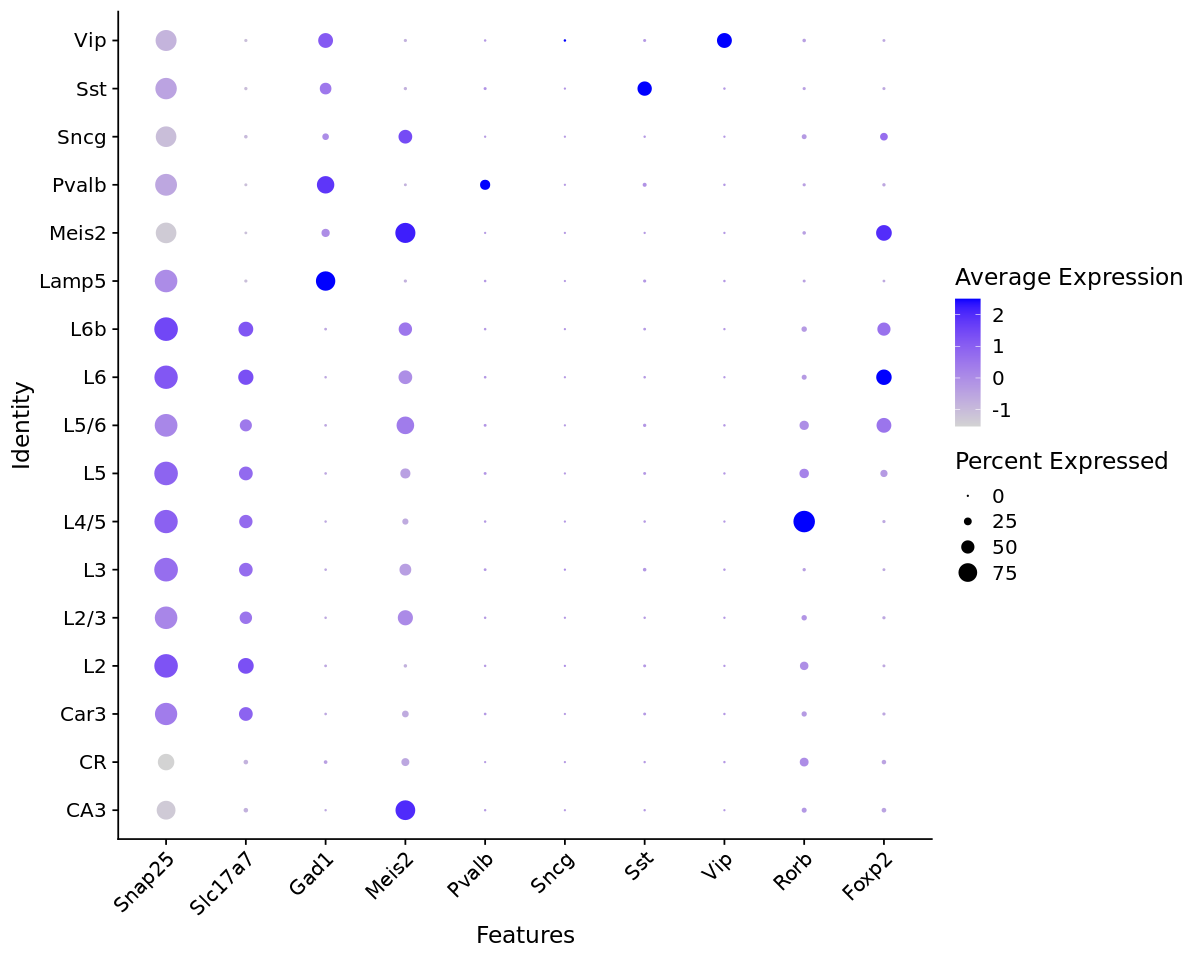

In [75]:
#pdf(file="plots/cortex/annotation/subtypes_known_marker_dotplot.pdf",
#   width = 10, height = 10)

options(repr.plot.width=10,repr.plot.height=8)
DefaultAssay(neurons) = "SCT" # do NOT use integrated assay to visualize gene expression
Idents(neurons) = "manual_celltypes"
Idents(neurons) = factor(Idents(neurons), levels = sort(as.character(unique(Idents(neurons)))))

DotPlot(neurons, features = genes)+ 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
#dev.off()

In [24]:
genes = c( "Gfap","Slc1a2","Slc1a3","Gja1","Aqp4", # astro
          "Flt1","Myl9","Xdh", # endothelial 
          "Slc17a7","Cpne4", # excitatory
          "Gad1","Gad2", # inhibitory
          "Itgam","Csf1r","Cx3cr1","P2ry12",# microglia
          "Pdgfra","Sox6","C1ql1","Cspg4",# OPC
          "Plp1","Mbp","Ccp110",# MFOL
          "Mog","Opalin","Ninj2","Hapln2",
          "Dock5","Bgn", # Smooth_muscle
          "Dcn","Slc6a13","Ptgds"  # VLMC
          )
        

In [25]:
pdf(file="plots/cortex/annotation/celltypes_marker_dotplot.pdf",
   width = 20, height = 8)

DefaultAssay(combined.sct) = "SCT" # do NOT use integrated assay to visualize gene expression
Idents(combined.sct) = "celltypes"
Idents(combined.sct) = factor(Idents(combined.sct), levels = sort(as.character(unique(Idents(combined.sct)))))
DotPlot(combined.sct, features = genes)+ 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
dev.off()

png 
  2

In [160]:
pdf(file="plots/cortex/annotation/UMAP_subtypes.pdf",
    width = 15, height = 10)
nclusters = length(unique(combined.sct$subtypes))
DimPlot(combined.sct, reduction = "umap", group.by = "subtypes", label = TRUE, label.size = 8, repel = TRUE, 
          cols = colorRampPalette(brewer.pal(9,"Set1"))(nclusters))
dev.off()

png 
  2

# Add celltypes and gen_celltypes metadata
Based on the subtypes annotation, we can group the cells into broader categories.

In [162]:
combined.sct$celltypes = combined.sct$subtypes

combined.sct$celltypes = gsub("\\<CA3\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<CR\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Car3\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L2 IT ENTl\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L2 IT ENTm\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L2/3 IT CTX\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L2/3 IT ENTl\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L2/3 IT PPP\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L2/3 IT RHP\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L3 IT ENT\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L4/5 IT CTX\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L5 IT CTX\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L5 PT CTX\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L5/6 NP CTX\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L6 CT CTX\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L6 IT CTX\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<L6b/CT ENT\\>","Excitatory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Meis2\\>","Inhibitory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Lamp5\\>","Inhibitory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Pvalb\\>","Inhibitory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Sncg\\>","Inhibitory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Sst\\>","Inhibitory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Vip\\>","Inhibitory",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<MFOL\\>","Oligodendrocyte",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<MOL\\>","Oligodendrocyte",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<SMC-Peri\\>","Smooth_muscle",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Micro-PVM\\>","Microglia",combined.sct$celltypes)


In [164]:
combined.sct$gen_celltype = combined.sct$celltypes

combined.sct$gen_celltype = gsub("\\<Excitatory\\>","Neuron",combined.sct$gen_celltype)
combined.sct$gen_celltype = gsub("\\<Inhibitory\\>","Neuron",combined.sct$gen_celltype)
combined.sct$gen_celltype = gsub("\\<Astrocyte\\>","Glial",combined.sct$gen_celltype)
combined.sct$gen_celltype = gsub("\\<OPC\\>","Glial",combined.sct$gen_celltype)
combined.sct$gen_celltype = gsub("\\<Oligodendrocyte\\>","Glial",combined.sct$gen_celltype)
combined.sct$gen_celltype = gsub("\\<Microglia\\>","Myeloid",combined.sct$gen_celltype)
combined.sct$gen_celltype = gsub("\\<Ependymal\\>","Stromal",combined.sct$gen_celltype)


# Plotting the 3 levels of annotations

In [5]:
color_ref = read.delim("ref/enc4_mouse_snrna_celltypes_c2c12.csv",sep=",",col.names = c("tissue","gen_celltype","celltypes",
                                                                              "subtypes","gen_celltype_color",
                                                                              "celltype_color","subtype_color"))
gen_celltype_colors = unique(color_ref[color_ref$tissue == "Cortex",c("gen_celltype","gen_celltype_color")])
rownames(gen_celltype_colors) = gen_celltype_colors$gen_celltype
gen_celltype_colors = gen_celltype_colors[sort(unique(combined.sct$gen_celltype)),]

pdf(file="plots/cortex/annotation/UMAP_final_gen_celltype.pdf",
   width = 15, height = 10)

DimPlot(combined.sct, reduction = "umap", 
        group.by = "gen_celltype", 
        label = TRUE, label.size = 8, repel = TRUE,
       cols = gen_celltype_colors$gen_celltype_color)

dev.off()

png 
  2

In [6]:
celltype_colors = unique(color_ref[color_ref$tissue == "Cortex",c("celltypes","celltype_color")])
rownames(celltype_colors) = celltype_colors$celltypes
celltype_colors = celltype_colors[sort(unique(combined.sct$celltypes)),]

pdf(file="plots/cortex/annotation/UMAP_final_celltypes.pdf",
    width = 15, height = 10)

DimPlot(combined.sct, reduction = "umap", 
        group.by = "celltypes", 
        label = TRUE, label.size = 8, repel = TRUE,
       cols = celltype_colors$celltype_color)

dev.off()

png 
  2

In [7]:
subtype_colors = unique(color_ref[color_ref$tissue == "Cortex",c("subtypes","subtype_color")])
rownames(subtype_colors) = subtype_colors$subtypes
subtype_colors = subtype_colors[sort(unique(combined.sct$subtypes)),]

pdf(file="plots/cortex/annotation/UMAP_final_subtypes.pdf",
    width = 15, height = 10)

DimPlot(combined.sct, reduction = "umap", 
        group.by = "subtypes", 
        label = TRUE, label.size = 8, repel = TRUE,
       cols = subtype_colors$subtype_color)

dev.off()

png 
  2

## Proportion plot of celltypes over timepoint

In [176]:
combined.sct_parse = subset(combined.sct,subset= technology == "Parse")

samples = sort(unique(combined.sct_parse$timepoint))
dflist = list()
for (i in 1:length(unique(combined.sct_parse$timepoint))){
  tp=combined.sct_parse@meta.data[combined.sct_parse@meta.data$timepoint == samples[i],]
  #tp=tp[complete.cases(tp),]
  tp_df=as.data.frame(table(tp$celltypes))
  tp_df$percentage=tp_df$Freq/nrow(tp)
  tp_df$timepoint=rep(i,nrow(tp_df))
  dflist[[i]]=tp_df
}
df = do.call(rbind, dflist)
df <- df[order(df$timepoint),]
colnames(df)= c("celltypes","Freq","percentage","timepoint")



In [177]:
pdf(file="plots/cortex/annotation/timepoint_celltypes_proportions.pdf",
    width = 15, height = 10)

ggplot(df, aes(x=timepoint, y=percentage, fill=celltypes)) + 
  geom_area()  +
  scale_fill_manual(values= celltype_colors$celltype_color) + 
  scale_x_continuous(breaks = c(1,2,3,4,5,6,7),labels= c("PND_04","PND_10","PND_14",
                                                         "PND_25","PND_36","PNM_02","PNM_18-20"))+
  scale_y_continuous(breaks = c(0,0.1,0.2,0.3,0.4,0.5,
                                0.6,0.7,0.8,0.9,1.0),labels= c("0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%")) + 
theme_minimal()+theme(text = element_text(size = 30)) + 
theme(axis.text.x = element_text(size = 30))  + 
theme(axis.text.y = element_text(size = 30))   + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
dev.off()

png 
  2

# Save 

In [182]:
saveRDS(combined.sct,file="seurat/cortex_Parse_10x_integrated.rds")

# Save embedding coordinates file

In [ ]:
cell_id = colnames(combined.sct)
coords = cbind(cell_id,combined.sct@reductions$umap@cell.embeddings,
               combined.sct@reductions$pca@cell.embeddings)
fn = paste0("ref/cortex/cortex_integrated_analysis_embedding_coordinates_noheader.tsv")
write.table(coords,file=fn,
            sep="\t",
            quote=F,
            row.names = F)
out = paste0("ref/cortex/cortex_integrated_analysis_embedding_coordinates.tsv")
system(paste0("cat ref/embedding_coordinates_header ", fn, "> ", out))
system(paste0("rm ", fn))

## Cerebro

In [3]:
combined.sct = readRDS("seurat/cortex_Parse_10x_integrated.rds")


In [4]:
# also add markers for my annotated cell types
combined.sct <- cerebroApp::getMarkerGenes(combined.sct, organism = 'mm',groups = c('subtypes','celltypes'), 
                                  min_pct = 0.1,thresh_logFC = 0.25, assay = "RNA")

combined.sct <- cerebroApp::getEnrichedPathways(combined.sct, adj_p_cutoff = 0.01, max_terms = 100)


DefaultAssay(combined.sct) = "integrated"

combined.sct <- RunUMAP(
  combined.sct,
  reduction.name = 'UMAP_3D',
  reduction.key = 'UMAP3D_',
  dims = 1:30,
  n.components = 3,
  seed.use = 100
)


library(cerebroApp)
exportFromSeurat(
  object = combined.sct,
  assay = "SCT",
  slot = "data",
  file = "seurat/cortex_Parse_10x_integrated.crb",
  experiment_name = "Mouse cortex",
  organism = "mm",
  groups = c('doublet_scores','doublets','library_accession','technology','species',
             'tissue','sex','timepoint','rep','sample','depth1','depth2','experiment',
             'experiment_batch','integration_batch','run_number','experiment_accession',
             'file_accession','atlas_predictions','S.Score','G2M.Score',
             'Phase','celltypes','gen_celltype','atlas_celltypes','subtypes','seurat_clusters','predicted.id'),
  nUMI = 'nCount_RNA',
  nGene = 'nFeature_RNA',
  use_delayed_array = FALSE,
  verbose = TRUE
)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
06:49:21 UMAP embedding parameters a = 0.9922 b = 1.112

06:49:22 Read 98867 rows and found 30 numeric columns

06:49:22 Using Annoy for neighbor search, n_neighbors = 30

06:49:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

06:49:38 Writing NN index file to temp file /tmp/RtmpmrS7Zf/file3bda4537d0e385

06:49:38 Searching Annoy index using 1 thread, search_k = 3000

